In [17]:
from google.colab import files
uploaded = files.upload()


Saving Tweets.csv to Tweets.csv


In [18]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('Tweets.csv')

# Check a few rows
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [19]:
# Step 2: Explore sentiment distribution
df['airline_sentiment'].value_counts()


,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


In [21]:
# Filter and copy to avoid SettingWithCopyWarning
df = df[df['airline_sentiment'].isin(['positive', 'negative'])].copy()

# Map sentiment to binary labels
df['label'] = df['airline_sentiment'].map({'negative': 0, 'positive': 1})


In [22]:
import re

# Cleaning function
def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)        # remove URLs
    text = re.sub(r"@\w+", "", text)           # remove mentions
    text = re.sub(r"#\w+", "", text)           # remove hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)    # remove special characters
    text = text.lower().strip()                # lowercase and strip
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_tweet)

# Preview cleaned tweets
df[['text', 'clean_text']].head()


,text,clean_text
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it
5,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay a flight for seats that d...
6,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly every time i fly vx this ear worm w...


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 4.1: Train-test split
X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4.2: TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # bigrams included
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [24]:
from sklearn.linear_model import LogisticRegression

# Step 5: Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 6.1: Predict on test data
y_pred = model.predict(X_test_tfidf)

# Step 6.2: Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Step 6.3: Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 6.4: Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9060199220441749

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1862
           1       0.93      0.56      0.70       447

    accuracy                           0.91      2309
   macro avg       0.91      0.77      0.82      2309
weighted avg       0.91      0.91      0.90      2309


Confusion Matrix:
[[1842   20]
 [ 197  250]]


In [26]:
import numpy as np

# Get feature names and coefficients
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = model.coef_.flatten()

# Top 20 positive and negative words
top_pos_indices = coefficients.argsort()[-20:][::-1]
top_neg_indices = coefficients.argsort()[:20]

print("🔺 Top Positive Words:")
print(feature_names[top_pos_indices])

print("\n🔻 Top Negative Words:")
print(feature_names[top_neg_indices])


🔺 Top Positive Words:
['thanks' 'thank' 'great' 'thank you' 'love' 'awesome' 'amazing' 'best'
 'good' 'thx' 'cool' 'the best' 'appreciate' 'no worries' 'worries'
 'excellent' 'well' 'nice' 'cant wait' 'kudos']

🔻 Top Negative Words:
['not' 'no' 'hours' 'delayed' 'worst' 'cancelled' 'why' 'nothing' 'hour'
 'hold' 'is' 'delay' 'hrs' 'dont' 'luggage' 'rude' 'bag' 'call' 'on hold'
 'the worst']


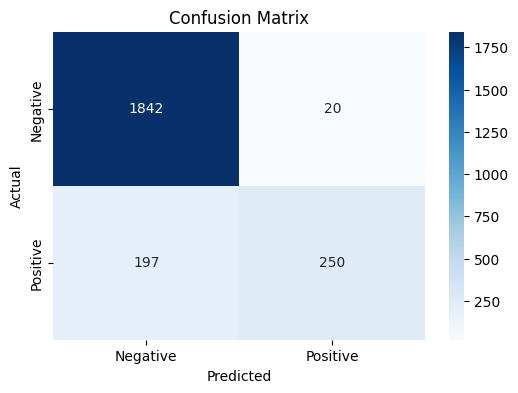

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [29]:
import pickle

# Save the trained model
with open('logistic_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!


In [31]:
# Define a function to clean and predict sentiment
def predict_sentiment(tweet):
    cleaned = clean_tweet(tweet)                         # clean the input
    features = vectorizer.transform([cleaned])           # vectorize
    prediction = model.predict(features)[0]              # predict
    return "Positive 😊" if prediction == 1 else "Negative 😠"

# Example usage
tweet1 = "I love the way the airline handled my issue today!"
tweet2 = "The flight was delayed for hours and no one helped us."

print("Tweet:", tweet1)
print("Sentiment:", predict_sentiment(tweet1))

print("\nTweet:", tweet2)
print("Sentiment:", predict_sentiment(tweet2))


Tweet: I love the way the airline handled my issue today!
Sentiment: Positive 😊

Tweet: The flight was delayed for hours and no one helped us.
Sentiment: Negative 😠
